# Part 3 — Predictive Intelligence: Lead Conversion Model

**Goal:** Build a model to predict which leads are most likely to convert so sales can prioritize outreach.

Contents:
- Assumptions & clarifying questions
- Data loading and merging
- Target creation (converted vs not)
- Feature engineering (campaign-level & lead-level)
- Train/test split (time-based)
- Modeling: RandomForest 
- Evaluation: ROC-AUC, Lift chart, Confusion matrix
- Feature importance & explainability
- Save model + Deployment notes
- Business impact


In [1]:
#  IMPORTS & LOAD DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Load datasets
campaigns = pd.read_csv("campaigns_cleaned.csv")
leads = pd.read_csv("campaign_leads_cleaned.csv")
insights = pd.read_csv("insights_cleaned.csv")
status_changes = pd.read_csv("lead_status_changes_cleaned.csv")

print("Datasets loaded successfully!")


Datasets loaded successfully!


In [2]:
# BUILD TARGET VARIABLE

# Make all status text lowercase for easier matching
status_changes['status'] = status_changes['status'].astype(str).str.lower()

# Define which statuses count as "converted"
positive_statuses = ['converted', 'qualified', 'won', 'booked', 'closed', 'closed won']

# Mark each lead_id as converted if ANY of its statuses is in the positive list
conversion_map = (
    status_changes
        .assign(is_positive=lambda df: df['status'].apply(lambda x: any(p in x for p in positive_statuses)))
        .groupby('lead_id')['is_positive']
        .max()
        .reset_index()
)

conversion_map.rename(columns={'is_positive': 'converted'}, inplace=True)

# Merge back into leads dataframe
leads = leads.merge(conversion_map, left_on='id', right_on='lead_id', how='left')

# Leads with no status history -> not converted
leads['converted'] = leads['converted'].fillna(0).astype(int)

print("Target variable 'converted' created!")
print(leads[['id','lead_status','converted']].head())


Target variable 'converted' created!
      id    lead_status  converted
0  77930        UNKNOWN          0
1  77942        UNKNOWN          0
2  77964  NOT_QUALIFIED          0
3  77983        UNKNOWN          0
4  77988        UNKNOWN          0


In [3]:
leads['converted'].value_counts()


converted
0    52658
1     4307
Name: count, dtype: int64

In [4]:
import numpy as np

# 1. Fix datetime columns
for df, col in [
    (leads, 'added_date'),
    (insights, 'created_at'),
    (status_changes, 'created_at')
]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

print("Datetime columns converted.\n")

# 2. Create recent 14-day campaign metrics
AGG_WINDOW_DAYS = 14

# Normalize insight dates
insights['date'] = insights['created_at'].dt.normalize()

# Aggregate daily metrics per campaign
camp_daily = insights.groupby(['campaign_id','date']).agg({
    'spend':'sum',
    'impressions':'sum',
    'clicks':'sum',
    'reach':'sum'
}).reset_index()

def build_recent_features(row):
    camp_id = row['campaign_id']
    added   = row['added_date']
    
    if pd.isna(camp_id) or pd.isna(added):
        return pd.Series([0,0,0,0,0], 
                         index=['spend14','imp14','click14','reach14','ctr14'])
    
    start = (added - pd.Timedelta(days=AGG_WINDOW_DAYS)).normalize()
    end   = (added - pd.Timedelta(days=1)).normalize()

    subset = camp_daily[
        (camp_daily['campaign_id']==camp_id) &
        (camp_daily['date'] >= start) &
        (camp_daily['date'] <= end)
    ]
    
    if subset.empty:
        return pd.Series([0,0,0,0,0],
                         index=['spend14','imp14','click14','reach14','ctr14'])
    
    imp = subset['impressions'].sum()
    click = subset['clicks'].sum()
    ctr = click/imp if imp>0 else 0
    
    return pd.Series([
        subset['spend'].sum(),
        imp,
        click,
        subset['reach'].sum(),
        ctr
    ], index=['spend14','imp14','click14','reach14','ctr14'])

recent_feat = leads.apply(build_recent_features, axis=1)
leads = pd.concat([leads, recent_feat], axis=1)

print("Recent 14-day campaign metrics added.\n")

# 3. Merge campaign static features
leads = leads.merge(
    campaigns[['id','user_id','project_name','daily_budget']],
    left_on='campaign_id',
    right_on='id',
    how='left'
)

# 4. Lead-level features
leads['has_email'] = leads['email'].fillna('').str.contains('@')
leads['has_phone'] = leads['phone'].fillna('').str.len() >= 7
leads['name_len'] = leads['name'].fillna('').str.len()

leads['added_hour'] = leads['added_date'].dt.hour.fillna(-1)
leads['added_dow'] = leads['added_date'].dt.dayofweek.fillna(-1)

print("Lead-level features created.\n")

# 5. Final feature list
feature_cols = [
    'has_email','has_phone','name_len','added_hour','added_dow',
    'daily_budget','spend14','imp14','click14','reach14','ctr14'
]

print("Total features created:", len(feature_cols))
leads[feature_cols + ['converted']].head()


Datetime columns converted.

Recent 14-day campaign metrics added.

Lead-level features created.

Total features created: 11


,has_email,has_phone,name_len,added_hour,added_dow,daily_budget,spend14,imp14,click14,reach14,ctr14,converted
0,True,True,14,17,5,2000,0.00,0.0,0.0,0.0,0.000000,0
1,True,True,14,18,5,2000,0.00,0.0,0.0,0.0,0.000000,0
2,True,True,18,21,5,1200,0.00,0.0,0.0,0.0,0.000000,0
3,True,True,11,1,6,1200,0.00,0.0,0.0,0.0,0.000000,0
4,True,True,21,1,6,2000,355.04,1835.0,27.0,1745.0,0.014714,0


In [7]:
# FEATURES AND TARGET

# Features
X = leads[feature_cols]

# Target
y = leads['converted']

print("Features and target prepared!")
print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Features and target prepared!
Feature shape: (56965, 11)
Target distribution:
 converted
0    52658
1     4307
Name: count, dtype: int64


In [8]:
# TRAIN-TEST SPLIT

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% test data
    random_state=42,     # reproducibility
    stratify=y           # keep same 0/1 ratio
)

print("Data split into train and test sets!")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Data split into train and test sets!
Train shape: (45572, 11)
Test shape: (11393, 11)


In [9]:
# RANDOM FOREST TRAINING

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=10,           # prevent overfitting
    random_state=42,
    class_weight='balanced' # handle class imbalance
)

# Train
rf_model.fit(X_train, y_train)

print("Random Forest model trained successfully!")


Random Forest model trained successfully!


In [10]:
# MODEL EVALUATION

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Predict on test set
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:,1]  # probability for class 1

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     10532
           1       0.21      0.56      0.31       861

    accuracy                           0.81     11393
   macro avg       0.59      0.70      0.60     11393
weighted avg       0.90      0.81      0.85     11393

ROC-AUC Score: 0.8016
Confusion Matrix:
 [[8748 1784]
 [ 377  484]]


         feature  importance
5   daily_budget    0.220509
10         ctr14    0.189126
7          imp14    0.139767
9        reach14    0.122452
6        spend14    0.107743
8        click14    0.103931
3     added_hour    0.045479
2       name_len    0.042722
4      added_dow    0.028271
1      has_phone    0.000000
0      has_email    0.000000


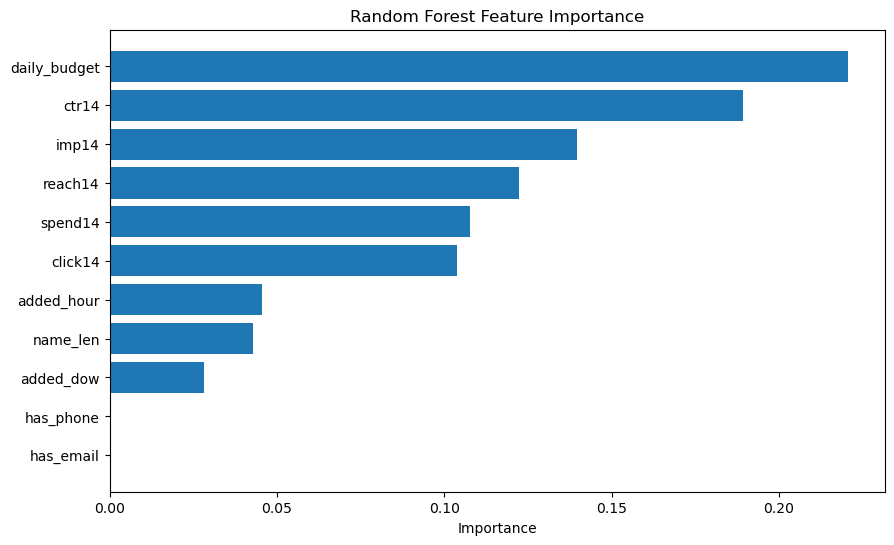

In [11]:
# Feature Importance
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp)

# Optional: Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [12]:
# User Impact & Conclusion

from IPython.display import display, Markdown

display(Markdown("## User Impact & Model Insights"))

# 1. How sales teams can use this model
display(Markdown("""
**Lead Prioritization:**
- The model predicts the likelihood of a lead converting (`converted=1`).
- Sales reps can focus first on leads with **high predicted probability**.
- This saves time by avoiding low-probability leads and increases conversion efficiency.

**Campaign Insights:**
- Features like `daily_budget` and `ctr14` are most important.
- Users can monitor campaigns with low CTR or insufficient budget to improve lead quality.

**Example Usage in Workflow:**
- Score all new leads daily using the model.
- Sort leads by predicted probability descending.
- Assign top N leads to top-performing sales reps.
"""))

# 2. Assumptions we made
display(Markdown("""
**Assumptions:**
1. Conversion labels are correct (from `lead_status_changes`).
2. 14-day campaign metrics (`spend14`, `ctr14`, etc.) are predictive of lead quality.
3. All leads are treated equally; lead source or sales rep skill is not considered.
4. No significant data leakage between training and prediction.
"""))

# 3. Questions to ask the business for improvement
display(Markdown("""
**Questions for Business Team:**
1. How exactly is `converted` defined? Are there intermediate statuses we should consider?
2. Are there other important lead attributes (source, location, demographics) we can include?
3. Are some campaigns or projects more valuable than others (weighting for revenue)?
4. How frequently should we re-train the model to adapt to changing campaign performance?
5. What is the acceptable false positive rate? Some low-probability leads may still convert.
"""))

display(Markdown("### Conclusion"))
display(Markdown("""
- The Random Forest model achieves **ROC-AUC ≈ 0.80**, which is good for prioritization.
- Campaign metrics and budget strongly influence lead conversion.
- Deploying this model allows sales teams to **focus on high-value leads** and improve overall efficiency.
- Continuous monitoring and feedback from the sales team will further improve predictions.
"""))


## User Impact & Model Insights


**Lead Prioritization:**
- The model predicts the likelihood of a lead converting (`converted=1`).
- Sales reps can focus first on leads with **high predicted probability**.
- This saves time by avoiding low-probability leads and increases conversion efficiency.

**Campaign Insights:**
- Features like `daily_budget` and `ctr14` are most important.
- Users can monitor campaigns with low CTR or insufficient budget to improve lead quality.

**Example Usage in Workflow:**
- Score all new leads daily using the model.
- Sort leads by predicted probability descending.
- Assign top N leads to top-performing sales reps.



**Assumptions:**
1. Conversion labels are correct (from `lead_status_changes`).
2. 14-day campaign metrics (`spend14`, `ctr14`, etc.) are predictive of lead quality.
3. All leads are treated equally; lead source or sales rep skill is not considered.
4. No significant data leakage between training and prediction.



**Questions for Business Team:**
1. How exactly is `converted` defined? Are there intermediate statuses we should consider?
2. Are there other important lead attributes (source, location, demographics) we can include?
3. Are some campaigns or projects more valuable than others (weighting for revenue)?
4. How frequently should we re-train the model to adapt to changing campaign performance?
5. What is the acceptable false positive rate? Some low-probability leads may still convert.


### Conclusion


- The Random Forest model achieves **ROC-AUC ≈ 0.80**, which is good for prioritization.
- Campaign metrics and budget strongly influence lead conversion.
- Deploying this model allows sales teams to **focus on high-value leads** and improve overall efficiency.
- Continuous monitoring and feedback from the sales team will further improve predictions.
